In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np; np.set_printoptions(linewidth=110);
import pandas as pd
# tell pandas to show all columns when we display a DataFrame
pd.set_option("display.max_columns", None)

# first we need a bit of import boilerplate
import os
import sys
from sys import platform
if platform == 'win32':
    sys.path.append('D:/Brain_Network/Code/')
    manifest_path = 'D:/Brain_Network/Data/Allen_Institute_Dataset/manifest.json'
    project_dir = 'D:/Brain_Network/'
elif platform =='darwin':
    sys.path.append('/Users/chenyu/Workspace/Brain_Network/Code/')
    manifest_path = '/Users/chenyu/Workspace/Brain_Network/Data/Allen_Institute_Dataset/manifest.json'
    project_dir = '/Users/chenyu/Workspace/Brain_Network/'
elif platform == 'linux':
    sys.path.append('/home/yuchen/workspace/Brain_Network/Code/')
    manifest_path = '/home/yuchen/workspace/Brain_Network/Data/Allen_Institute_Dataset/manifest.json'
    project_dir = '/home/yuchen/workspace/Brain_Network/'
else:
    print('Add new computer system settings.')

import matplotlib.pyplot as plt
import random
# import seaborn
import scipy
import scipy.io as sio
from scipy.ndimage.filters import gaussian_filter
import seaborn
from tqdm import tqdm
from tqdm.notebook import trange
import time
import itertools

import data_model
import fine_time_coupling_model
import util
import hierarchical_sampling_model
import hierarchical_model_generator
import jitter


In [3]:
import allensdk
import pandas
import h5py
import pynwb
import hdmf
import matplotlib
print('allensdk', allensdk.__version__)
print('pandas', pandas.__version__)
print('h5py', h5py.__version__)
print('pynwb', pynwb.__version__)
print('hdmf', hdmf.__version__)
print('matplotlib', matplotlib.__version__)

allensdk 2.2.0
pandas 1.3.5
h5py 2.8.0
pynwb 1.4.0
hdmf 2.2.0
matplotlib 3.4.1


# Data generator

#### Poisson

In [10]:
generator = hierarchical_model_generator.HierarchicalModelGenerator()
lmbd_0, lmbd_1, lmbd_2 = 20, 20, 20
trial_length, num_trials = 2, 500
trial_window = [0, trial_length]
generator_par = None
spike_times_x = generator.generate_poisson_spike_times(lmbd_0, trial_length, num_trials)
spike_times_y = generator.generate_poisson_spike_times(lmbd_1, trial_length, num_trials)
spike_times_z = generator.generate_poisson_spike_times(lmbd_2, trial_length, num_trials)

#### Hawkes process

In [114]:
generator = hierarchical_model_generator.HierarchicalModelGenerator()
trial_length = 2
generator_par = {'trial_length': trial_length, 'trial_window':[0, trial_length], 'num_trials': 500, 'random_seed': None,
    'type': 'square', 'mu': [20., 20., 20], 'num_nodes': 3, 
    'alpha': [[0.0,0.0,5.0], [0.0,0.0,5.0], [0.0,0.0,0.0]], 'beta': [[0.05,0.05,0.05], [0.05,0.05,0.05], [1.0,1.0,1.0]]}
spike_times = generator.generate_hawkes_spike_times(generator_par, verbose=2)
spike_times_x = spike_times[2]
spike_times_y = spike_times[1]
spike_times_z = spike_times[0]

lambda stable: [25. 25. 20.]
Gamma
[[0.   0.   0.25]
 [0.   0.   0.25]
 [0.   0.   0.  ]]
100%|█████████████████████████████████████████████████████████████| 500/500 [00:22<00:00, 21.78it/s]


#### Amarasingham data.

In [ ]:
generator = hierarchical_model_generator.HierarchicalModelGenerator()
np.random.seed(2)
trial_length = 2
num_peaks = 30
baseline = 10
num_trials = 250
sigma = 0.04

file_path = project_dir + 'Output/fig/eg_amarasingham_data.pdf'
spike_times = generator.generate_amarasingham_example_spike_times(num_peaks, sigma, trial_length, num_trials*2, 
        baseline, sample_type='density', verbose=2, file_path=None)
spike_times_x = spike_times[:num_trials]
spike_times_y = spike_times[num_trials:]

#### Amarasingham + coupling filter.

x --> z,   y--> z

In [15]:
generator = hierarchical_model_generator.HierarchicalModelGenerator()
trial_length = 2
trial_window = [0, trial_length]
generator_par = {'trial_length': trial_length, 'trial_window': trial_window,
    'num_peaks': 30, 'num_trials': 100, 'baseline': 10, 'sigma': 0.04, 'random_seed': 6, 
    'type': 'square', 'num_nodes': 3,
    'alpha': [[0.,10,10], [0.0,0.0,0.0], [0.0,0.0,0.0]], 'beta': [[1.0,0.05,0.05], [1.0,1.0,0.05], [1.0,1.0,1.0]]}
spike_times = generator.generate_amarasingham_coupling_filter_spike_times(generator_par, verbose=2)
spike_times_x = spike_times[2]
spike_times_y = spike_times[1]
spike_times_z = spike_times[0]

lambda_max (proposal): 509.41
lambda stable: [127.35  63.68  63.68]
100%|█████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  6.05it/s]


z --> x, z --> y

In [19]:
generator = hierarchical_model_generator.HierarchicalModelGenerator()
trial_length = 2
trial_window = [0, trial_length]
generator_par = {'trial_length': trial_length, 'trial_window': trial_window,
    'num_peaks': 30, 'num_trials': 100, 'baseline': 10, 'sigma': 0.04, 'random_seed': 6, 
    'type': 'square', 'num_nodes': 3,
    'alpha': [[0.,0.,0.], [10.,0.,0.], [10.,0.,0.]], 'beta': [[0.,0.,0.], [.05,0.,0.], [.05,0.,0.]]}
spike_times = generator.generate_amarasingham_coupling_filter_spike_times(generator_par, verbose=2)
spike_times_x = spike_times[2]
spike_times_y = spike_times[1]
spike_times_z = spike_times[0]

lambda_max (proposal): 509.41
lambda stable: [63.68 95.51 95.51]
100%|█████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.34it/s]


##### very strong coupling 0,1,2,3 --> 4,5

In [340]:
generator = hierarchical_model_generator.HierarchicalModelGenerator()
trial_length = 5
trial_window = [0, trial_length]
# Inject spike trains. (can introduce coupling effects)
alpha = np.zeros([6,6]); alpha[-1,:4] = 15; alpha[-2,:4] = 15
beta = np.zeros([6,6]); beta[-1,:4] = 0.01; beta[-2,:4] = 0.01

# model_name = 'poisson_background_gaussian_mixture_square_spike_driver' + \
#         f'alpha{15}_beta{10}ms_sigma_100ms_trials{100}_nonrepeated'
# generator_par = { 'num_trials': 100, 'trial_length': trial_length, 'trial_window': trial_window,
#     'rho': 20, 'mu':20, 'baseline': 10, 'window': 'gaussian', 'sigma': 0.1, 'random_seed': 1, 
#     'type': 'square', 'num_nodes': 6, 'alpha': alpha, 'beta': beta}

# model_name = 'nobackground_square_spike_driver' + \
#         f'alpha{15}_beta{10}ms_sigma_100ms_trials{100}_nonrepeated'
# generator_par = { 'num_trials': 100, 'trial_length': trial_length, 'trial_window': trial_window,
#     'rho': 0, 'mu':0, 'baseline': 20, 'window': 'gaussian', 'sigma': 1, 'random_seed': 2, 
#     'type': 'square', 'num_nodes': 6, 'alpha': alpha, 'beta': beta}

alpha = np.zeros([6,6]);
beta = np.zeros([6,6]); beta[-1,:4] = 0.01; beta[-2,:4] = 0.01
model_name = 'poisson_background_gaussian_mixture_square_spike_driver' + \
        f'alpha{0}_sigma_100ms_trials{100}_nonrepeated'
generator_par = { 'num_trials': 100, 'trial_length': trial_length, 'trial_window': trial_window,
    'rho': 30, 'mu':30, 'baseline': 10, 'window': 'gaussian', 'sigma': 0.1, 'random_seed': 1, 
    'type': 'square', 'num_nodes': 6, 'alpha': alpha, 'beta': beta}

spike_times = generator.generate_amarasingham_coupling_filter_spike_times_nonrepeated(generator_par, verbose=2)

100%|█████████████████████████████████████████████████████████████| 100/100 [01:41<00:00,  1.01s/it]


##### normal coupling 0,1,2,3 --> 4,5    4 --> 5

In [3]:
generator = hierarchical_model_generator.HierarchicalModelGenerator()
trial_length = 5
trial_window = [0, trial_length]
num_trials = 150
# Inject spike trains. (can introduce coupling effects)
alpha = np.zeros([6,6]); alpha[5,[0,1,2,3]] = -3; alpha[4,[0,1,2,3]] = 2; alpha[4,5]=2
beta = np.zeros([6,6]) + 0.03;

# model_name = 'poisson_background_gaussian_mixture_square_spike_driver' + \
#         f'alpha{15}_beta{10}ms_sigma_100ms_trials{100}_nonrepeated'
# generator_par = { 'num_trials': 100, 'trial_length': trial_length, 'trial_window': trial_window,
#     'rho': 20, 'mu':20, 'baseline': 10, 'window': 'gaussian', 'sigma': 0.1, 'random_seed': 1, 
#     'type': 'square', 'num_nodes': 6, 'alpha': alpha, 'beta': beta}

# model_name = 'nobackground_square_spike_driver' + \
#         f'alpha{15}_beta{10}ms_sigma_100ms_trials{100}_nonrepeated'
# generator_par = { 'num_trials': 100, 'trial_length': trial_length, 'trial_window': trial_window,
#     'rho': 0, 'mu':0, 'baseline': 20, 'window': 'gaussian', 'sigma': 1, 'random_seed': 2, 
#     'type': 'square', 'num_nodes': 6, 'alpha': alpha, 'beta': beta}

model_name = f'poisson_background_gaussian_mixture_multivariate_sigma_100ms_trials{num_trials}_nonrepeated'
generator_par = {'num_trials': num_trials, 'trial_length': trial_length, 'trial_window': trial_window,
    'rho': 20, 'mu':20, 'baseline': 15, 'window': 'gaussian', 'sigma': 0.1, 'random_seed': 1, 
    'type': 'square', 'num_nodes': 6, 'alpha': alpha, 'beta': beta}

spike_times = generator.generate_amarasingham_coupling_filter_spike_times_nonrepeated(generator_par, verbose=2)


100%|█████████████████████████████████████████████████████████████| 150/150 [03:14<00:00,  1.30s/it]


##### Load data

In [133]:
data_dir = project_dir + 'Output/jitter/multivariate_coupling_data/'
file_path = data_dir + 'poisson_background_gaussian_mixture_multivariate_nodes6_sigma_100ms_trials200_nonrepeated_generator_par.pkl'
generator_par = util.load_variable(file_path)
file_path = data_dir + 'poisson_background_gaussian_mixture_multivariate_nodes6_sigma_100ms_trials200_nonrepeated_itr3.pkl'
spike_times = util.load_variable(file_path)

trial_length = generator_par['trial_length']
trial_window = generator_par['trial_window']
print(generator_par)

# file_path = data_dir + 'poisson_background_gaussian_mixture_square_spike_driveralpha0_sigma_100ms_trials100_nonrepeated_generator_par.pkl'
# generator_par = util.load_variable(file_path)
# file_path = data_dir + 'poisson_background_gaussian_mixture_square_spike_driveralpha0_sigma_100ms_trials100_nonrepeated_itr0.pkl'
# spike_times = util.load_variable(file_path)

{'num_trials': 200, 'trial_length': 5, 'trial_window': [0, 5], 'rho': 20, 'mu': 20, 'baseline': 10, 'window': 'gaussian', 'sigma': 0.1, 'random_seed': None, 'type': 'square', 'num_nodes': 6, 'alpha': array([[ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 2.,  2.,  2.,  2.,  0.,  0.],
       [-2., -2., -2., -2.,  0.,  0.]]), 'beta': array([[0.03, 0.03, 0.03, 0.03, 0.03, 0.03],
       [0.03, 0.03, 0.03, 0.03, 0.03, 0.03],
       [0.03, 0.03, 0.03, 0.03, 0.03, 0.03],
       [0.03, 0.03, 0.03, 0.03, 0.03, 0.03],
       [0.03, 0.03, 0.03, 0.03, 0.03, 0.03],
       [0.03, 0.03, 0.03, 0.03, 0.03, 0.03]])}


In [5]:
spike_times_x0 = spike_times[0]
spike_times_x1 = spike_times[1]
spike_times_x2 = spike_times[2]
spike_times_x3 = spike_times[3]
spike_times_x4 = spike_times[4]
spike_times_x5 = spike_times[5]

##### Save data.

In [341]:
data_dir = project_dir + 'Output/jitter/multivariate_coupling_data/'

file_path = data_dir + model_name + '_generator_par.pkl'
util.save_variable(file_path, generator_par)
file_path = data_dir + model_name + f'_itr{0}.pkl'
util.save_variable(file_path, spike_times, verbose=False)

util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/multivariate_coupling_data/poisson_background_gaussian_mixture_square_spike_driveralpha0_sigma_100ms_trials100_nonrepeated_generator_par.pkl


#### Check data statistics.

layers 3, nodes 6, trials 200
meanFR [29.288 29.781 29.909 29.633 36.301 22.841]	meanISI [29.626 30.138 30.232 29.966 36.668 23.176]


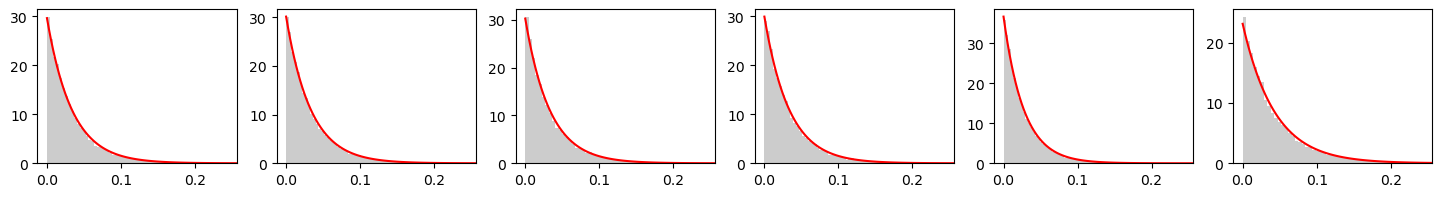

layers 3, nodes 6, trials 200


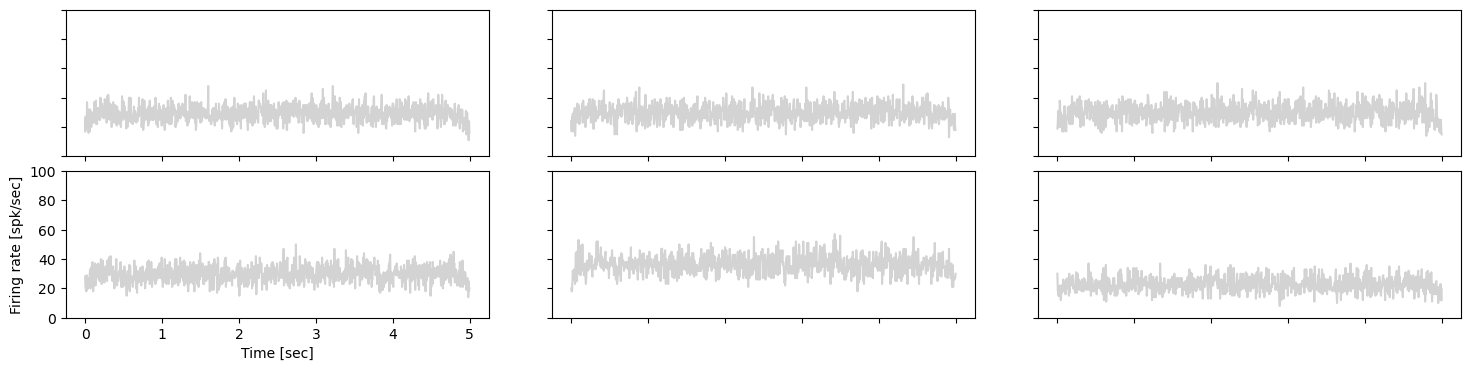

In [123]:
generator = hierarchical_model_generator.HierarchicalModelGenerator()
generator.spike_times_statistics(spike_times, generator_par['trial_length'], verbose=1)
_=generator.plot_psth(spike_times, generator_par['trial_length'], 0.005, ylim=[0, 100])
# generator.plot_hawkes_psth(spike_times, trial_length, 0.2, filter_par)
# generator.plot_hawkes_intensity(filter_par, spike_times, trial_length, node_ids=[0,1], trial_ids=[0], plot_window=[0, 0.5], ylim=[None, None])

#### Kernel width plug-in estimator.

100%|███████████████████████████████████████████████████████████████| 32/32 [00:10<00:00,  3.12it/s]
optimal kernel width  130.0


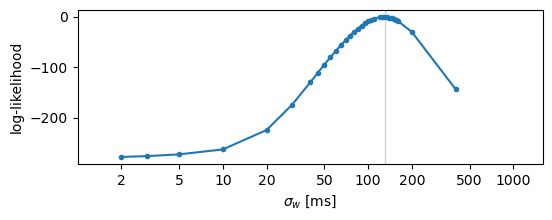

(array([0.002, 0.003, 0.005, 0.01 , 0.02 , 0.03 , 0.04 , 0.045, 0.05 , 0.055, 0.06 , 0.065, 0.07 , 0.075,
        0.08 , 0.085, 0.09 , 0.095, 0.1  , 0.105, 0.11 , 0.12 , 0.125, 0.13 , 0.135, 0.14 , 0.145, 0.15 ,
        0.155, 0.16 , 0.2  , 0.4  ]),
 array([-2.77518565e+02, -2.75908804e+02, -2.72465299e+02, -2.62641269e+02, -2.24217979e+02, -1.73863863e+02,
        -1.29471762e+02, -1.10833267e+02, -9.44042640e+01, -7.99273219e+01, -6.71557477e+01, -5.58816977e+01,
        -4.59405556e+01, -3.72054551e+01, -2.95785288e+01, -2.29818125e+01, -1.73492046e+01, -1.26210259e+01,
        -8.73949420e+00, -5.64734708e+00, -3.28651206e+00, -5.25826614e-01, -1.11522807e-02,  0.00000000e+00,
        -4.40490051e-01, -1.28413898e+00, -2.48610280e+00, -4.00532055e+00, -5.80435370e+00, -7.84931535e+00,
        -2.99579353e+01, -1.43311331e+02]),
 0.13)

In [140]:
jittertool = jitter.JitterTool()
model_par = {'dt': 0.001, 'trial_window': [0, trial_length], 'append_nuisance': ['const', 'gaussian_kernel']}
jittertool.estimate_optimal_jitter_window_width(spike_times[3], spike_times[2], model_par)

100%|███████████████████████████████████████████████████████████████| 32/32 [00:10<00:00,  3.05it/s]
optimal kernel width  155.0


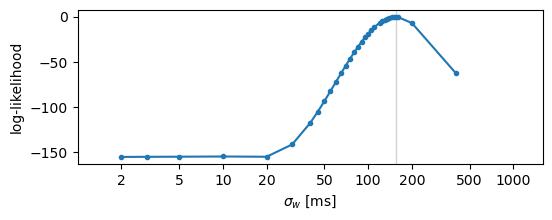

In [125]:
# model_par = {'dt': 0.001, 'trial_window': [0, trial_length], 'append_nuisance': ['const', 'gaussian_kernel']}
# _=jittertool.estimate_optimal_jitter_window_width_simple(spike_times_x[:20], spike_times_y[:20], model_par)
model_par = {'dt': 0.001, 'trial_window': [0, trial_length], 'append_nuisance': ['const', 'gaussian_kernel']}
_=jittertool.estimate_optimal_jitter_window_width(spike_times[5], spike_times[2], model_par)

# Bivariate nuisance regression.
Coupling filter does not strongly introduce the transitivity, as the consequency is too weak.

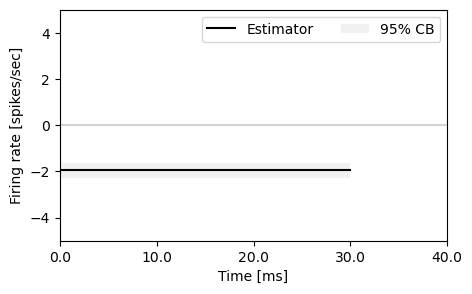

In [145]:
jittertool = jitter.JitterTool()
model_par_bspline = {'filter_type': 'bspline', 'num_knots': 4, 'knot_space_par': 0.1, 'filter_length': 0.04, 'num_tail_drop': 1,
             'append_nuisance': ['const', 'gaussian_kernel'], 'kernel_width': 0.1,
             'const_offset': 0, 'learning_rate': 0.9, 'max_num_itrs': 100, 'epsilon': 1e-6}
model_par_square_hawkes = {'filter_type': 'square', 'filter_length': 0.03,
             'append_nuisance': ['const'],
             'const_offset': 0, 'learning_rate': 0.9, 'max_num_itrs': 100, 'epsilon': 1e-6}
model_par_square = {'filter_type': 'square', 'filter_length': 0.03,
             'append_nuisance': ['const', 'gaussian_kernel'], 'kernel_width': 0.13,
             'const_offset': 0, 'learning_rate': 0.9, 'max_num_itrs': 100, 'epsilon': 1e-6}

model_par_hat = jittertool.bivariate_continuous_time_coupling_filter_regression(spike_times[1], spike_times[5], trial_window, model_par_square)
jittertool.plot_continuous_time_bivariate_regression_model_par(model_par_hat, xlim=[0,0.04], ylim=[-5, 5], file_path=None)

# Multivariate nuisance regression.

### Bivariate regression.

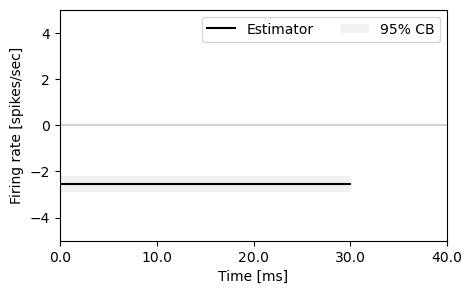

In [143]:
jittertool = jitter.JitterTool()
model_par_bspline = {'filter_type': 'bspline', 'num_knots': 4, 'knot_space_par': 0.1, 'filter_length': 0.04, 'num_tail_drop': 1,
             'append_nuisance': ['const', 'gaussian_kernel'], 'kernel_width': 0.1,
             'const_offset': 0, 'learning_rate': 0.9, 'max_num_itrs': 100, 'epsilon': 1e-6}
model_par_square = {'filter_type': 'square', 'filter_length': 0.03,
             'append_nuisance': ['const', 'gaussian_kernel'], 'kernel_width': 0.11,
             'const_offset': 0, 'learning_rate': 0.9, 'max_num_itrs': 100, 'epsilon': 1e-6}
model_par_square_hawkes = {'filter_type': 'square', 'filter_length': 0.03,
             'append_nuisance': ['const'],
             'const_offset': 0, 'learning_rate': 0.9, 'max_num_itrs': 100, 'epsilon': 1e-6}

model_par_hat = jittertool.bivariate_continuous_time_coupling_filter_regression(spike_times[3], spike_times[5], trial_window, model_par_square)
jittertool.plot_continuous_time_bivariate_regression_model_par(model_par_hat, xlim=[0,0.04], ylim=[-5, 5], file_path=None)


##### Loop

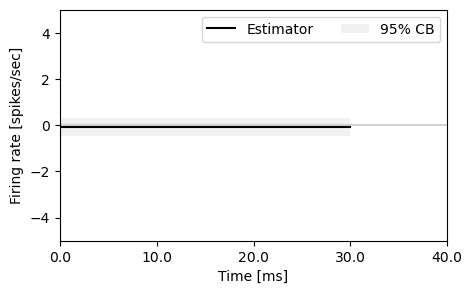

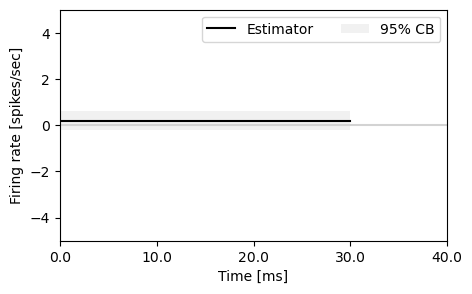

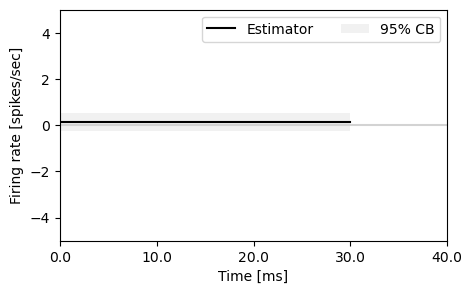

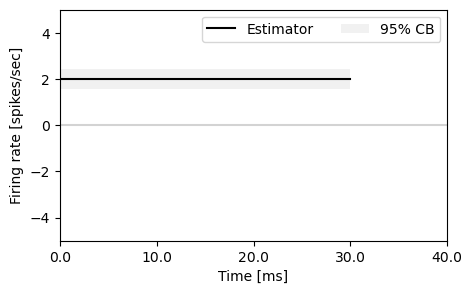

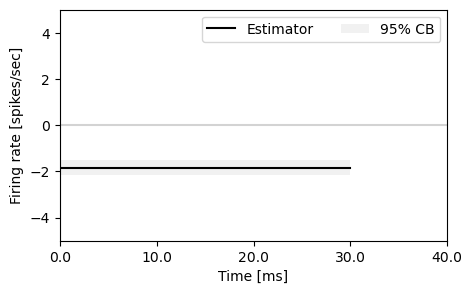

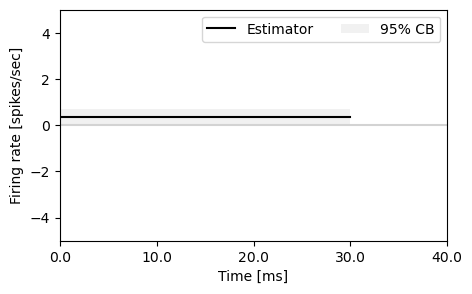

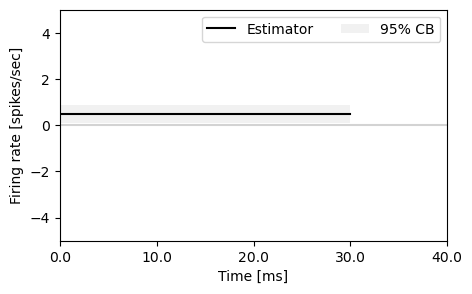

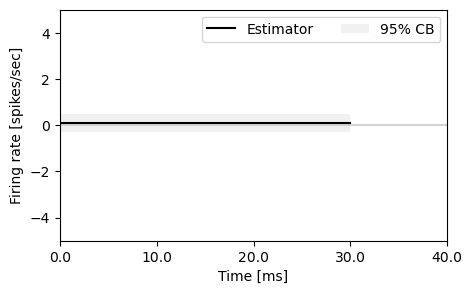

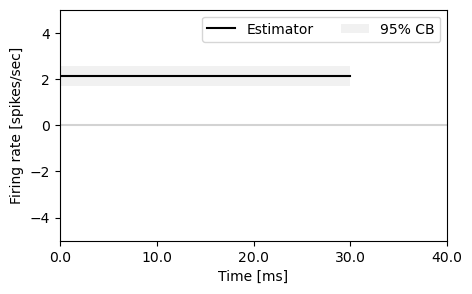

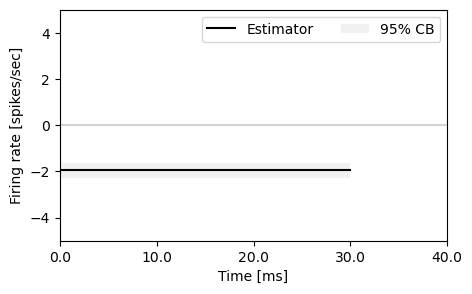

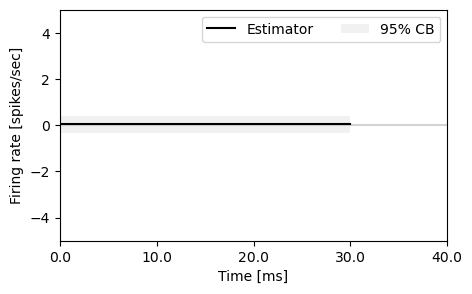

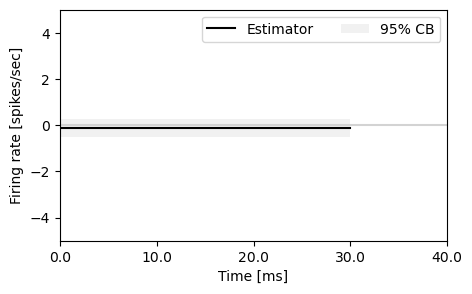

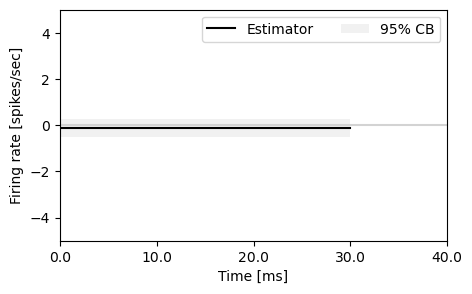

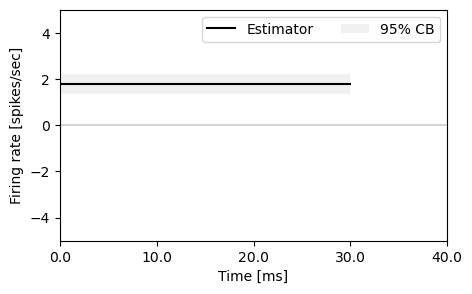

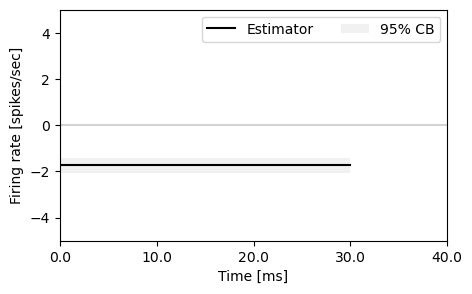

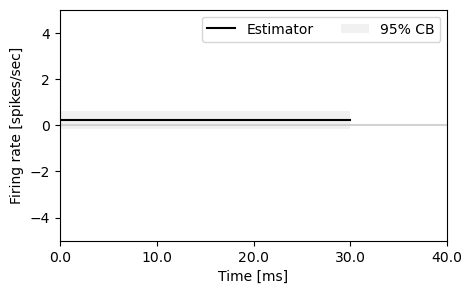

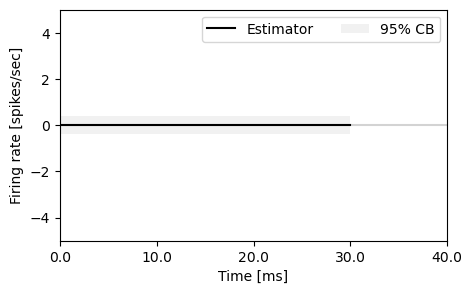

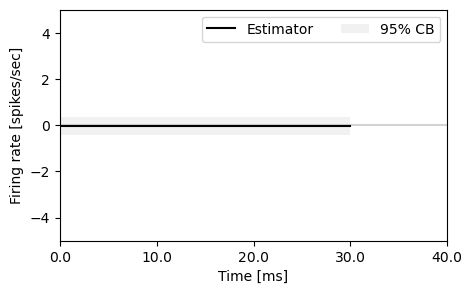

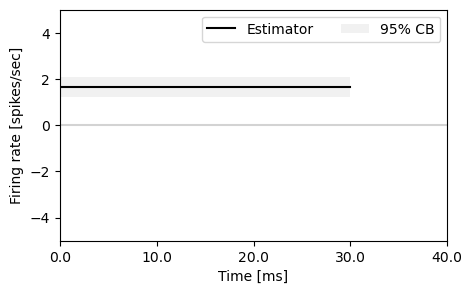

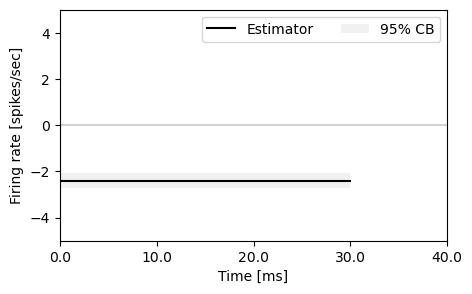

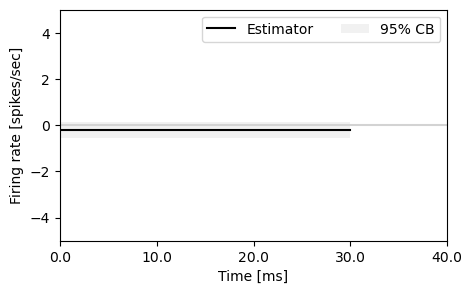

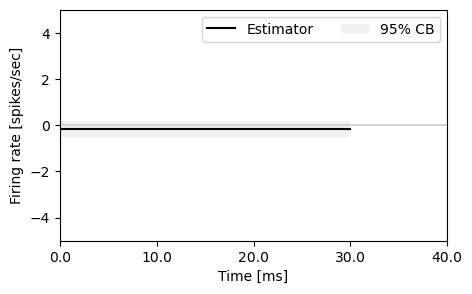

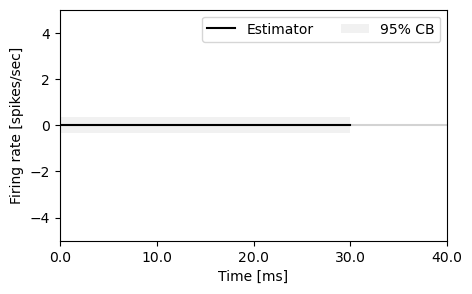

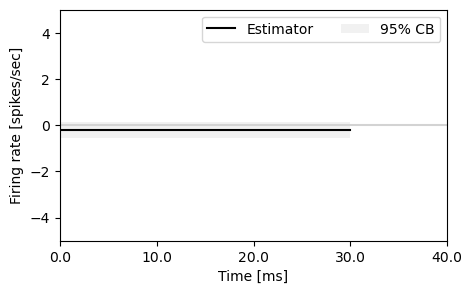

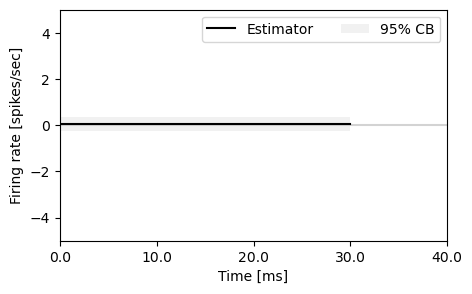

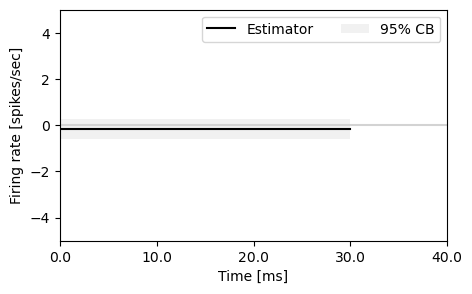

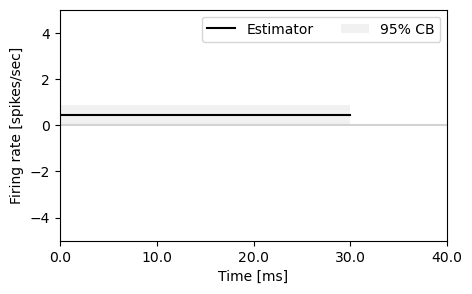

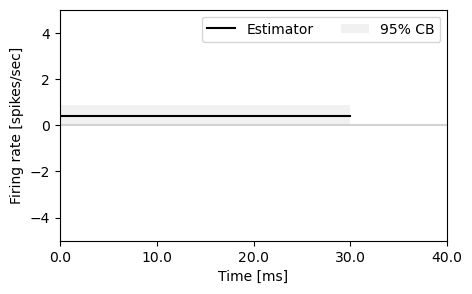

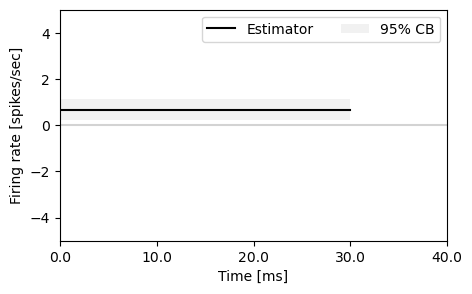

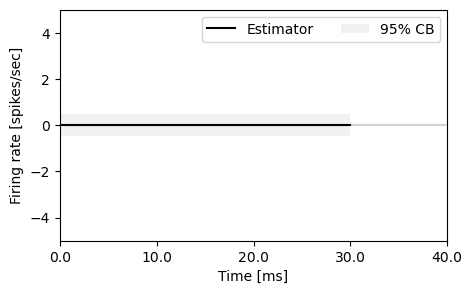

In [150]:
jittertool = jitter.JitterTool()

num_nodes = 6
nodes = list(range(num_nodes))

multi_model_par_hat = {}
for src, tgt in itertools.permutations(nodes, 2):
    model_par_square = {'filter_type': 'square', 'filter_length': 0.03,
                 'append_nuisance': ['const', 'gaussian_kernel'], 'kernel_width': 0.13,
                 'const_offset': 0, 'learning_rate': 0.9, 'max_num_itrs': 100, 'epsilon': 1e-6}
    multi_model_par_hat[(src, tgt)] = jittertool.bivariate_continuous_time_coupling_filter_regression(spike_times[src], spike_times[tgt], trial_window, model_par_square)
    jittertool.plot_continuous_time_bivariate_regression_model_par(multi_model_par_hat[(src, tgt)], xlim=[0,0.04], ylim=[-5, 5], file_path=None)


### Multivaraite Hawkes.

In [95]:
jittertool = jitter.JitterTool()

model_par_const = {'append_nuisance': ['const'], 'const_offset': 0, 'learning_rate': 0.9, 'max_num_itrs': 100, 'epsilon': 1e-6}

model_par_square0 = {'filter_type': 'square', 'filter_length': 0.03,
             'append_nuisance': [],
             'const_offset': 0, 'learning_rate': 0.9, 'max_num_itrs': 100, 'epsilon': 1e-6}

model_par_square = {'filter_type': 'square', 'filter_length': 0.03,
             'append_nuisance': ['gaussian_kernel'], 'kernel_width': 0.1,
             'const_offset': 0, 'learning_rate': 0.9, 'max_num_itrs': 100, 'epsilon': 1e-6}

model_par_bspline = {'filter_type': 'bspline', 'num_knots': 4, 'knot_space_par': 0.2, 'filter_length': 0.04, 'num_tail_drop': 1,
             'append_nuisance': ['gaussian_kernel'], 'kernel_width': 0.1,
             'const_offset': 0, 'learning_rate': 0.9, 'max_num_itrs': 100, 'epsilon': 1e-5}

tgt_node = 2
src_nodes = [0,1,3,4,5]

src_spikes = [[]] + [spike_times[n] for n in src_nodes]
tgt_spikes = spike_times[tgt_node]
model_par_nodes = [model_par_const] + [model_par_square0.copy() for n in range(len(src_nodes))]  # constant baseline + filters.

model_par_hat = jittertool.multivariate_continuous_time_coupling_filter_regression(src_spikes, tgt_spikes, trial_window, model_par_nodes)


##### Loop

In [90]:
num_nodes = 6
multi_model_par_hat = {}
for tgt_node in range(num_nodes):
    src_nodes = list(range(num_nodes)); src_nodes.remove(tgt_node)
    src_spikes = [[]] + [spike_times[n] for n in src_nodes]
    tgt_spikes = spike_times[tgt_node]
    model_par_nodes = [model_par_const] + [model_par_square0.copy() for n in range(len(src_nodes))]  # constant baseline + filters.
    multi_model_par_hat[tgt_node] = jittertool.multivariate_continuous_time_coupling_filter_regression(src_spikes, tgt_spikes, trial_window, model_par_nodes)


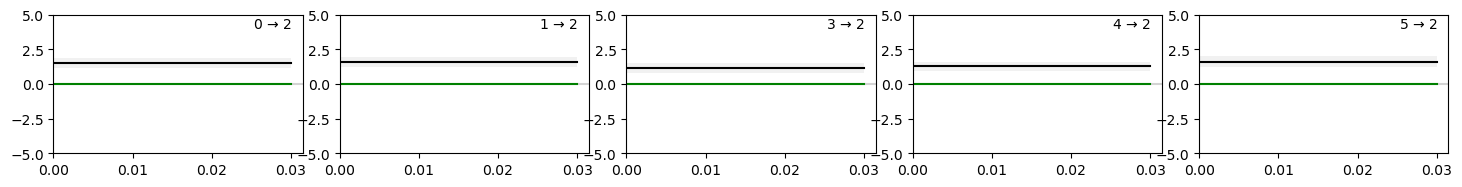

In [97]:
file_path = project_dir + 'Output/fig/xxx.pdf'
jittertool.plot_continuous_time_multivariate_regression_model_par_one_target(model_par_hat, generator_par, src_nodes, tgt_node, ylim=[-5, 5], file_path=None)

In [ ]:
file_path = project_dir + 'Output/fig/driver_network_alpha15_beta10ms_rho20_multivariate_reg.pdf'
jittertool.plot_continuous_time_bivariate_regression_model_par(model_par_hat_multi[-1], xlim=[0,0.04], ylim=[-5, 10], file_path=file_path)

In [305]:
model_dir = project_dir + 'Output/jitter/multivariate_coupling_model/'
model_name = 'poisson_background_gaussian_mixture_square_spike_driver' + \
        f'alpha{15}_beta{10}ms_sigma_100ms_trials{100}_nonrepeated'
file_path = model_dir + f'{model_name}_kernel{100}ms_multivariate_model_par.pkl'
# util.save_variable(file_path, model_par_hat_multi)

util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/multivariate_coupling_model/poisson_background_gaussian_mixture_square_spike_driveralpha15_beta10ms_sigma_100ms_trials100_nonrepeated_kernel100ms_multivariate_model_par.pkl


# Jitter CCG.

100%|█████████████████████████████████████████████████████████████| 200/200 [00:04<00:00, 47.46it/s]


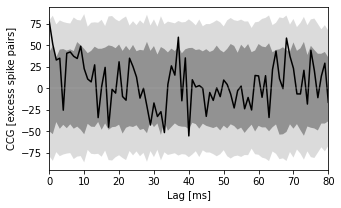

In [161]:
jittertool = jitter.JitterTool()
spk_bin_width = 0.001
lag_range = [0, 0.08]
jitter_window_width = 0.1
distribution_type='mc_sim'
num_jitter = 200
file_path = project_dir + 'Output/fig/eg_amarasingham_square_filter_weak_ccg_spk5ms_jitterwindow120ms.pdf'
ret_vals = jittertool.cross_correlation_jitter(spike_times_x4, spike_times_x5, spk_bin_width, trial_length, lag_range, jitter_window_width,
    distribution_type=distribution_type, num_jitter=num_jitter, ci_alpha=0.05, verbose=True, file_path=None)

# Jitter correction for coupling filters

In [165]:
jittertool = jitter.JitterTool()
model_par = {'filter_type': 'bspline', 'num_knots': 6, 'knot_space_par': 0.05, 'filter_length': 0.05, 'num_tail_drop': 1, 
             'append_nuisance': ['const'], 'const_offset': 0, 'num_jitter': 10, 'jitter_window_width': 0.12, 
             'learning_rate': 0.9, 'max_num_itrs': 100, 'epsilon': 1e-5}
# model_par = {'filter_type': 'square', 'filter_length': 0.04,
#              'append_nuisance': ['const'], 'const_offset': 0, 'num_jitter': 10, 'jitter_window_width': 0.12,
#              'learning_rate': 0.9, 'max_num_itrs': 100, 'epsilon': 1e-5}
model_par_raw, model_par_jitter = jittertool.bivariate_continuous_time_coupling_filter_regression_jitter(
    spike_times_x, spike_times_y, trial_window, model_par, verbose=True)

100%|███████████████████████████████████████████████████████████████| 10/10 [00:10<00:00,  1.08s/it]


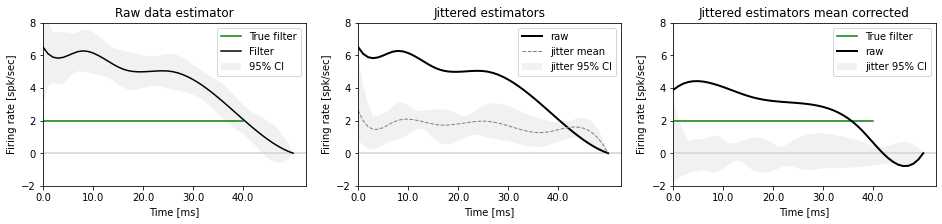

In [166]:
file_path = project_dir + 'Output/fig/eg_amarasingham_negsquare_filter_jitter_regression_jitterwindow120ms.pdf'
jittertool.plot_continuous_time_bivariate_regression_jitter_model_par(model_par_raw, model_par_jitter,
    generator_par, ylim=[-2, 8], file_path=None)